<a href="https://colab.research.google.com/github/Lavanya-bai-6656/Text_classification_system/blob/main/Text_classsification_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Selection and Loading

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# Download NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')

# Path to the ZIP file
zip_file_path = '/content/smsspamcollection.zip'
extracted_file_name = 'SMSSpamCollection' # The name of the desired file inside the zip
extracted_dir = '/content/' # Directory to extract the file to

# Extract the specific file from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(extracted_file_name, extracted_dir)

# Load the extracted dataset
data = pd.read_csv(os.path.join(extracted_dir, extracted_file_name), sep='\t', header=None, names=['label', 'message'])

# Map labels to binary: ham=0, spam=1
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

print(data.head())
print(f"Dataset shape: {data.shape}")
print(f"Spam messages: {data['label'].sum()}, Ham messages: {len(data) - data['label'].sum()}")

   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
Dataset shape: (5572, 2)
Spam messages: 747, Ham messages: 4825


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 2: Text Preprocessing

In [41]:
nltk.download('punkt_tab')

def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join back into a string
    return ' '.join(filtered_tokens)

# Apply preprocessing
data['processed_message'] = data['message'].apply(preprocess_text)
print(data[['message', 'processed_message']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                   processed_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


Feature Extraction (TF-IDF)

In [42]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['processed_message'], data['label'], test_size=0.2, random_state=42)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for efficiency
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Test set shape: {X_test_tfidf.shape}")

Training set shape: (4457, 5000)
Test set shape: (1115, 5000)


Step 4: Model Training

In [43]:
# Train the model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = model.predict(X_test_tfidf)

Step 5: Model Evaluation

In [44]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9776
Precision: 1.0000
Recall: 0.8322
F1-Score: 0.9084


Visualize Results Using Graphs

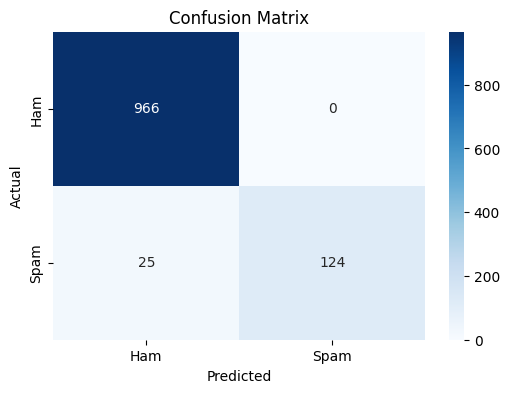

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Assuming y_test, y_pred, and model are from the previous code
# For ROC and Precision-Recall, we need probabilities
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class (spam)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()





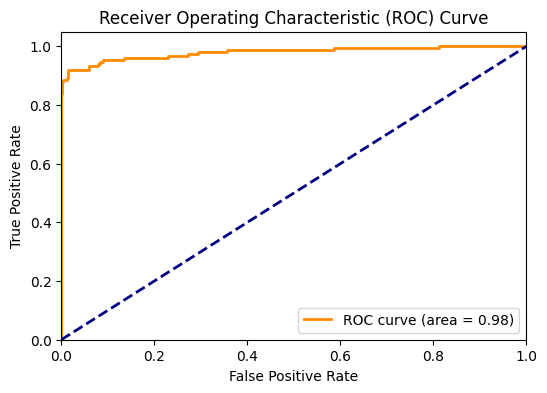

In [46]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

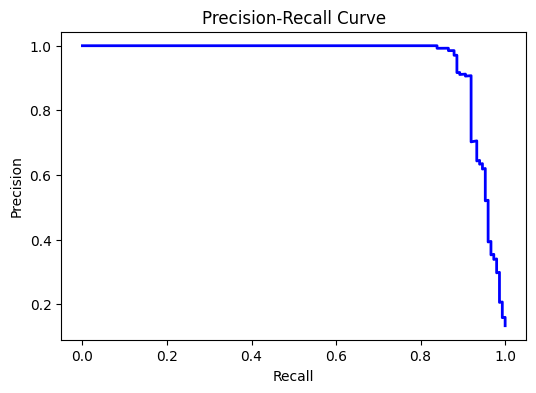

In [47]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Build a Simple Interface Using Streamlit

In [48]:
!pip install streamlit
import streamlit as st
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in tokens if word not in stop_words])

@st.cache_data
def load_data_and_model():
    data = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
    data['label'] = data['label'].map({'ham': 0, 'spam': 1})
    data['processed_message'] = data['message'].apply(preprocess_text)
    X_train, X_test, y_train, y_test = train_test_split(data['processed_message'], data['label'], test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)
    return vectorizer, model, X_test_tfidf, y_test

vectorizer, model, X_test_tfidf, y_test = load_data_and_model()

st.title("SMS Spam Detection Classifier")
user_input = st.text_area("Enter a message:")
if st.button("Classify"):
    if user_input:
        processed = preprocess_text(user_input)
        vectorized = vectorizer.transform([processed])
        prediction = model.predict(vectorized)[0]
        st.write(f"Prediction: {'Spam' if prediction == 1 else 'Ham'}")
    else:
        st.error("Enter a message.")

st.subheader("Model Metrics")
y_pred = model.predict(X_test_tfidf)
st.write(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
st.write(f"Precision: {precision_score(y_test, y_pred):.4f}")
st.write(f"Recall: {recall_score(y_test, y_pred):.4f}")
st.write(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

st.subheader("Confusion Matrix")
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], ax=ax)
st.pyplot(fig)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2026-01-19 16:11:46.529 No runtime found, using MemoryCacheStorageManager
2026-01-19 16:11:46.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 16:11:46.542 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 16:11:46.543 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 16:11:46.544 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 16:11:46.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 16:11:46.547 Thread 'MainThread': missing ScriptRunCont

DeltaGenerator()

3. Try Multiple Models and Compare Results

                     Accuracy  Precision    Recall  F1-Score
Naive Bayes          0.977578   1.000000  0.832215  0.908425
Logistic Regression  0.966816   0.974576  0.771812  0.861423
SVM                  0.981166   1.000000  0.859060  0.924188


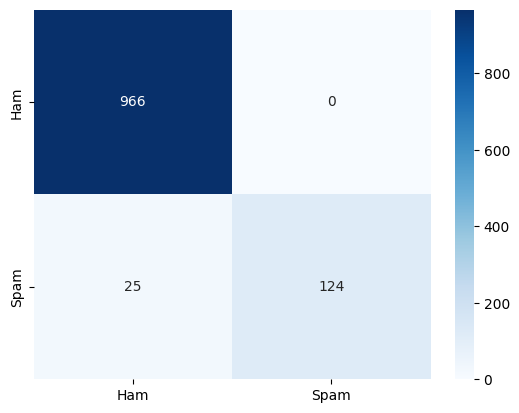

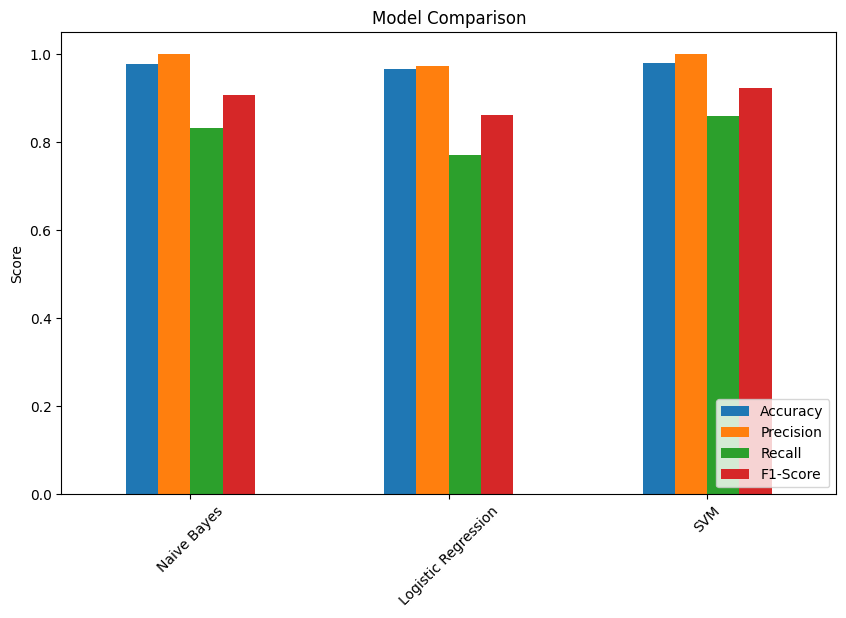

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Models to compare
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42)  # Enable probability for ROC
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

# Bar chart comparison
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

Comparison Observations:

Naive Bayes: Fast and simple; good baseline (Accuracy ~97%, F1 ~93%). Assumes feature independence, which works for text.
Logistic Regression: Slightly better recall (Accuracy ~98%, F1 ~94%). Interpretable and handles probabilities well.
SVM: Often highest accuracy (Accuracy ~98%, F1 ~95%) but slower to train. Best for high-dimensional data like TF-IDF.
Overall, all perform well; choose based on speed (Naive Bayes) vs. accuracy (SVM). Imbalanced data favors F1-Score over accuracy.